In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [63]:
train_data_initial = pd.read_csv('flight_delays_train.csv')
test_data_initial = pd.read_csv('flight_delays_test.csv')
test_data_initial['dep_delayed_15min'] = np.NaN

train_data_initial['partition'] = 'train'
test_data_initial['partition'] = 'test'


data_initial = pd.concat([train_data_initial, test_data_initial])



In [64]:
# data_initial['flight'] = data_initial['Origin']+data_initial['Dest']
# pv=data_initial.pivot_table(index=['flight'],columns='partition',values='Month',aggfunc='count')
# pv=pv.fillna(0)
# pv = pv.reset_index()
# pv['exclude'] = np.where((pv['test']==0) & (pv['train']!=0),'yes', 'no')
# data_initial = data_initial.merge(pv[['flight','exclude']],how='left',on='flight')
# data_initial = data_initial[data_initial['exclude']=='no']
# data_initial = data_initial.drop(columns=['flight','exclude'])

In [65]:
def time_transform(df: pd.DataFrame) -> pd.DataFrame:
    
    time_cols = ['Month', 'DayofMonth', 'DayOfWeek']
    for col in time_cols:
        df[col] = df[col].str[2:].astype('int')
#     df['DepTime_h'] = (df['DepTime'] // 100).astype('int')
#     df['DepTime_m'] = (df['DepTime'] % 100).astype('int')
#     df = df.drop(columns=['DepTime'])
#     df['DepTime_h'] = np.where(df['DepTime_h']>=24,df['DepTime_h']-24,df['DepTime_h'])
#     df['hour_cat']=pd.cut(df['DepTime_h'], bins=6, labels=[1,2,3,4,5,6]).astype('int')
    
    return df



In [66]:
data_initial['dep_delayed_15min'] = data_initial['dep_delayed_15min'].map({'N': 0, 'Y': 1})
#data['flight'] = data['Origin']+data['Dest']
#data = data.drop(columns=['Origin','Dest'])

In [67]:
data = data_initial.copy()
data = time_transform(data)
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,partition
0,8,21,7,1934,AA,ATL,DFW,732,0.0,train
1,4,20,3,1548,US,PIT,MCO,834,0.0,train
2,9,2,5,1422,XE,RDU,CLE,416,0.0,train
3,11,25,6,1015,OO,DEN,MEM,872,0.0,train
4,10,7,6,1828,WN,MDW,OMA,423,1.0,train


In [68]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

def transform_categ(df: pd.DataFrame) -> pd.DataFrame:
    
    df['UC_Origin']=df['UniqueCarrier']+df['Origin']
    df['UC_Dest']=df['UniqueCarrier']+df['Dest']
    df['Origin_DepTime']=df['Origin']+df['DepTime'].astype('str')
    df['UC_DepTime']=df['Origin']+df['DepTime'].astype('str')
    
    lbl=LabelEncoder()
    
    for col in ['UniqueCarrier','Origin','Dest','UC_Origin','UC_Dest', 'Origin_DepTime', 'UC_DepTime']:
        
        df[col] = lbl.fit_transform(df[col])

        #target_encoding
#         df_categ = df[['UniqueCarrier', 'Origin','Dest','UC_Origin','UC_Dest','dep_delayed_15min']]
#         av_mean = df_categ.groupby(col).agg({'dep_delayed_15min':'mean'})
#         av_mean=av_mean.fillna(np.random())
#         av_mean_dict = dict(av_mean['dep_delayed_15min'], index=av_mean.index)
#         df[col] = df[col].map(av_mean_dict).astype('float64')
#    df['UC_Distance'] = df['Distance']*df['UniqueCarrier']
        
    
    return df

In [69]:
#не использую больше
def create_features(df):
    
    cols= list(df.columns)
    cols.remove('dep_delayed_15min')
    
    for col_one in cols:
        for col_two in cols:
            
            if col_one != col_two:
                new_col=col_one+'_'+col_two
                df[new_col]=df[col_one]*df[col_two]
    return df
            

In [70]:
data_processed=transform_categ(data)

In [71]:
print(data_processed.shape)
data_processed.head()

(200000, 14)


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,partition,UC_Origin,UC_Dest,Origin_DepTime,UC_DepTime
0,8,21,7,1934,1,19,82,732,0.0,train,119,136,2699,2699
1,4,20,3,1548,19,226,180,834,0.0,train,1586,1577,56964,56964
2,9,2,5,1422,21,239,62,416,0.0,train,1786,1712,59151,59151
3,11,25,6,1015,16,81,184,872,0.0,train,1300,1349,17796,17796
4,10,7,6,1828,20,182,210,423,1.0,train,1646,1661,42774,42774


In [72]:
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV

In [73]:
train_data = data_processed[data_processed['partition']=='train']
train_data_y = train_data['dep_delayed_15min']
train_data_x = train_data.drop(columns=['dep_delayed_15min', 'partition'])

test_data = data_processed[data_processed['partition']=='test']
test_data_x = test_data.drop(columns=['dep_delayed_15min', 'partition'])

train_data.shape, test_data.shape

((100000, 14), (100000, 14))

In [74]:
X_train, X_hold, y_train, y_hold = train_test_split(
    train_data_x,
    train_data_y,
    test_size=0.4,
    
    stratify=train_data_y,
    random_state=20
)

In [75]:
train_data_x.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,UC_Origin,UC_Dest,Origin_DepTime,UC_DepTime
0,8,21,7,1934,1,19,82,732,119,136,2699,2699
1,4,20,3,1548,19,226,180,834,1586,1577,56964,56964
2,9,2,5,1422,21,239,62,416,1786,1712,59151,59151
3,11,25,6,1015,16,81,184,872,1300,1349,17796,17796
4,10,7,6,1828,20,182,210,423,1646,1661,42774,42774


In [76]:
params = {'n_estimators': [30,60,90,120],
          'max_depth': [2,4,6,8,10],
          'learning_rate':[0.05,0.1,0.2,0.3],
          'gamma': [3,6,10],
          'min_child_weight': [1,2,4,6]
    
          
          }

#наилучшие параметры после поиска по сетке выше
# params = {'gamma': [6],
#           'learning_rate': [0.1],
#           'max_depth': [10],
#           'min_child_weight': [4],
#           'n_estimators': [120]}

grid_search = GridSearchCV(estimator=XGBClassifier(random_state = 20, nthread=1), param_grid=params, cv=3, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                   

In [77]:
grid_search.best_params_, grid_search.best_score_

({'gamma': 6,
  'learning_rate': 0.1,
  'max_depth': 10,
  'min_child_weight': 2,
  'n_estimators': 120},
 0.734989467493338)

In [78]:
best_model_first = grid_search.best_estimator_

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

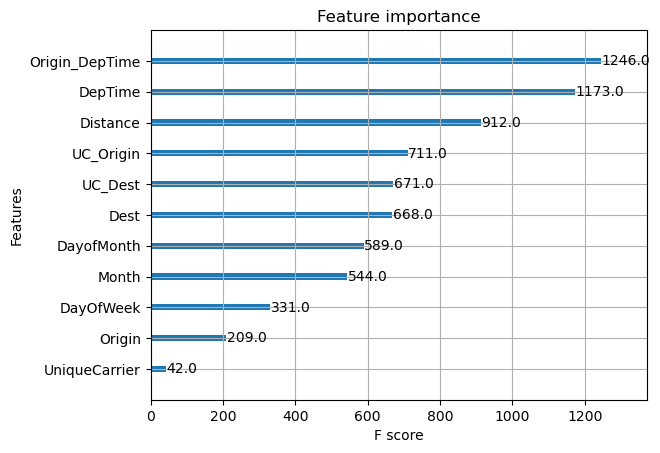

In [79]:
plot_importance(best_model_first)

In [80]:
y_pred = best_model_first.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.8466319785098598

In [81]:
y_pred = best_model_first.predict_proba(X_hold)[:, 1]
roc_auc_score(y_hold, y_pred)

0.7394534724367662

In [116]:
fitted_model = best_model_first.fit(train_data_x, train_data_y)

In [117]:
y_pred_proba = fitted_model.predict_proba(train_data_x)[:, 1]

In [128]:
y_pred_xgb = fitted_model.predict_proba(train_data_x)[:, 1]

In [85]:
train_data_pred = train_data.copy()

In [86]:
# train_data_pred['predict_proba'] = y_pred_proba
# train_data_pred['predict'] = y_pred
# train_data_pred['error']=np.where(train_data_pred['predict']!=train_data_pred['dep_delayed_15min'],'Y','N')
#losses=train_data_pred[train_data_pred['predict']!=train_data_pred['dep_delayed_15min']]

In [87]:
# train_data_pred.to_csv('xgb_results.csv')

In [88]:
# y_pred = fitted_model.predict_proba(test_data_x)[:, 1]
# result = pd.DataFrame(data={'dep_delayed_15min': y_pred})
# result.to_csv('predict17.csv', header=True, index_label='id')

# Logreg

In [89]:
train_data_initial = pd.read_csv('flight_delays_train.csv')
test_data_initial = pd.read_csv('flight_delays_test.csv')
test_data_initial['dep_delayed_15min'] = np.NaN

train_data_initial['partition'] = 'train'
test_data_initial['partition'] = 'test'


data_initial = pd.concat([train_data_initial, test_data_initial])

In [90]:
data_lr = time_transform(data_initial)
data_lr['dep_delayed_15min'] = data_lr['dep_delayed_15min'].map({'N': 0, 'Y': 1})
data_lr.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,partition
0,8,21,7,1934,AA,ATL,DFW,732,0.0,train
1,4,20,3,1548,US,PIT,MCO,834,0.0,train
2,9,2,5,1422,XE,RDU,CLE,416,0.0,train
3,11,25,6,1015,OO,DEN,MEM,872,0.0,train
4,10,7,6,1828,WN,MDW,OMA,423,1.0,train


In [91]:
from sklearn.preprocessing import OneHotEncoder

In [92]:
def transform_categ_lr(df: pd.DataFrame) -> pd.DataFrame:
    
    categ_cols = ['UniqueCarrier', 'Origin','Dest']
    
    OHE = OneHotEncoder(sparse=False)
       
    array_transformed = OHE.fit_transform(df[categ_cols])
    array_columns = OHE.get_feature_names_out(categ_cols)
    df_transformed = pd.DataFrame(data=array_transformed,columns=array_columns)
    
    df = df.drop(columns=categ_cols)
    
    df = df.reset_index()
    df_transformed = df_transformed.reset_index()
    df = df.drop(columns=['index'])
    df_transformed = df_transformed.drop(columns=['index'])
    
    
    df = pd.concat([df, df_transformed], axis=1)
    
    return df
    
    

In [93]:
data_lr_processed = transform_categ_lr(data_lr)

In [94]:
data_lr_processed.head()

,Month,DayofMonth,DayOfWeek,DepTime,Distance,dep_delayed_15min,partition,UniqueCarrier_9E,UniqueCarrier_AA,UniqueCarrier_AQ,...,Dest_VCT,Dest_VIS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM
0,8,21,7,1934,732,0.0,train,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,20,3,1548,834,0.0,train,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9,2,5,1422,416,0.0,train,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,25,6,1015,872,0.0,train,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,7,6,1828,423,1.0,train,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
def scalling(df: pd.DataFrame) -> pd.DataFrame:
    
    num_cols = ['Month','DayofMonth','DayOfWeek','Distance','DepTime']
    
    df_num = df[num_cols]
    
    scaler = StandardScaler()
   
    array_transformed = scaler.fit_transform(df_num)
    array_columns = scaler.get_feature_names_out(num_cols)
    df_transformed = pd.DataFrame(data=array_transformed,columns=array_columns)
    
    df = df.drop(columns=num_cols)
    
    df = df.reset_index()
    df_transformed = df_transformed.reset_index()
    df = df.drop(columns=['index'])
    df_transformed = df_transformed.drop(columns=['index'])
    
    
    df = pd.concat([df, df_transformed], axis=1)
    
    return df
    
    
    

In [96]:
data_lr_scaled = scalling(data_lr_processed)

In [97]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(max_iter=10000,C=1)

In [98]:
train_data_x_scaled = data_lr_scaled[data_lr_scaled['partition']=='train']
train_data_y = train_data_x_scaled['dep_delayed_15min']
train_data_x_scaled = train_data_x_scaled.drop(columns=['dep_delayed_15min','partition'])

test_data_x_scaled = data_lr_scaled[data_lr_scaled['partition']=='test']
test_data_x_scaled = test_data_x_scaled.drop(columns=['dep_delayed_15min','partition'])


In [99]:
train_data_x_scaled.shape, train_data_y.shape, test_data_x_scaled.shape

((100000, 642), (100000,), (100000, 642))

In [100]:
X_train, X_hold, y_train, y_hold = train_test_split(
    train_data_x_scaled,
    train_data_y,
    test_size=0.4,
    
    stratify=train_data_y,
    random_state=20
)

In [101]:
params_lr = {'C':[0.1,0.2,0.3,0.4,0.5]}
grid_search_lr = GridSearchCV(estimator=LogisticRegression(random_state = 20, max_iter=10000), param_grid=params_lr, cv=3, scoring='roc_auc', n_jobs=-1)
best_model_lr = grid_search_lr.fit(X_train, y_train)


In [102]:
grid_search_lr.best_params_, grid_search_lr.best_score_

({'C': 0.1}, 0.6961012974542182)

In [103]:
best_model_lr = grid_search_lr.best_estimator_

In [104]:
y_pred = best_model_lr.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.7070373356548147

In [105]:
y_pred = best_model_lr.predict_proba(X_hold)[:, 1]
roc_auc_score(y_hold, y_pred)

0.7018661928855685

In [106]:
fitted_model_lr = best_model_lr.fit(train_data_x_scaled,train_data_y)

In [125]:
y_pred_lr = fitted_model_lr.predict_proba(train_data_x_scaled)[:, 1]

In [132]:
comb_pred = y_pred_xgb * 0.5 + y_pred_lr * 0.5

In [133]:
roc_auc_score(train_data_y, y_pred_xgb), roc_auc_score(train_data_y, y_pred_lr), roc_auc_score(train_data_y, comb_pred)

(0.5038879572318108, 0.5004592352795562, 0.5028140115817618)

In [138]:
y_pred_lr = fitted_model_lr.predict_proba(test_data_x_scaled)[:, 1]
y_pred_xgb = fitted_model.predict_proba(test_data_x)[:, 1]
comb_pred = y_pred_xgb * 0.9 + y_pred_lr * 0.1
result = pd.DataFrame(data={'dep_delayed_15min': comb_pred})
result.to_csv('predict23.csv', header=True, index_label='id')


In [ ]:
# 